
# Diagnose und Klassifikation von Diabetes mellitus mithilfe maschinellen Lernens

Hier finden Sie den gesamten Code, den der Autor für die Analyse verwendet hat.

Auch einzusehen unter: https://github.com/NicoPiel/LiteraturSeminar

In [1]:
# Setup

import numpy as np

# Ein Zufalls-Seed für Reproduzierbarkeit
np.random.seed(42)

from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, utils
import tensorboard

%load_ext tensorboard
sns.set_theme()

tf.keras.backend.set_floatx('float64')

print(f"GPUs für die Berechnung: {len(tf.config.experimental.list_physical_devices('GPU'))}")

GPUs für die Berechnung: 0


In [2]:
# Daten importieren
data = pd.read_csv('data/diabetes.csv')

# Nullen durch NaN ersetzen
data["Glucose"] = data["Glucose"].replace(0, np.nan)
data["BloodPressure"] = data["BloodPressure"].replace(0, np.nan)
data["SkinThickness"] = data["SkinThickness"].replace(0, np.nan)
data["Insulin"] = data["Insulin"].replace(0, np.nan)
data["BMI"] = data["BMI"].replace(0, np.nan)
data["DiabetesPedigreeFunction"] = data["DiabetesPedigreeFunction"].replace(0, np.nan)
data["Age"] = data["Age"].replace(0, np.nan)

# NaN Werte imputieren
imputer = KNNImputer(n_neighbors=3)

data_imputed = pd.DataFrame(imputer.fit_transform(data))
data_imputed.columns = data.columns

# Vorbereitung

Als Erstes möchten wir uns ein wenig Übersicht verschaffen, also Data Exploration betreiben.

In [3]:
# Spalten

data_imputed.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
# Übersicht verschaffen

data_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,126.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,106.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,33.0,325.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [5]:
data_imputed.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,3.742775,121.865968,72.386802,29.394870,154.245303,32.571038,0.471193,33.132225,0.343931
std,3.323801,30.691555,12.405154,10.878381,113.830777,7.143838,0.325669,11.777230,0.475104
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.000000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,30.000000,125.000000,32.300000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.725000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


Die einzelnen Spalten haben folgende Bedeutung:

- **Pregnancies:** Anzahl der bisherigen (erfolgreichen und gescheiterten) Schwangerschaften
- **Glucose:** 75g-2-h-oGTT in $\frac{\text{mg}}{\text{dl}}$. Glukosewert nach 75g Kohlenhydraten und zwei Stunden Wartezeit
- **BloodPressure:** Diastolischer Blutdruck in $\text{mm} \cdot \text{Hg}$
- **SkinThickness:** Dicke der Trizepshautfalte in $\text{mm}$
- **Insulin:** Seruminsulin nach 2 Stunden in $\frac{\text{µU}}{\text{ml}}$
- **BMI:** Body-Mass-Index in $\frac{\text{kg}}{\text{m}^2}$
- **DiabetesPedigreeFunction:** Stammbaumfunktion des Patienten
- **Age:** Alter in Jahren
- **Outcome:** Klassifikation. 1 = Diabetes, 0 = kein Diabetes

In [6]:
# Keine sichtbare Beziehung zwischen

#sns.pairplot(data = data_imputed, hue="Outcome")
#plt.savefig('pairplot.png', dpi=300)

In [7]:
# Pearson-Koeffizienten für alle Spalten

for col in data_imputed:
    for col2 in data_imputed:
        if col != col2:
            arr1 = data_imputed[col].to_numpy()
            arr2 = data_imputed[col2].to_numpy()
        
            pearson = stats.pearsonr(arr1, arr2)
            
            if (pearson[0] > 0.3) or (pearson[0] < -0.3):
                print(f"{col} -> {col2}: r = {np.round(pearson[0], 2)}, p = {np.round(pearson[1], 2)}")

Pregnancies -> Age: r = 0.54, p = 0.0
Glucose -> Insulin: r = 0.51, p = 0.0
Glucose -> Outcome: r = 0.49, p = 0.0
BloodPressure -> Age: r = 0.33, p = 0.0
SkinThickness -> BMI: r = 0.54, p = 0.0
Insulin -> Glucose: r = 0.51, p = 0.0
BMI -> SkinThickness: r = 0.54, p = 0.0
Age -> Pregnancies: r = 0.54, p = 0.0
Age -> BloodPressure: r = 0.33, p = 0.0
Outcome -> Glucose: r = 0.49, p = 0.0


Aus den Pearson-Koeffizienten lässt sich schließen, dass die klinischen Werte nur wenig direkten Einfluss aufeinander haben.

Die Anzahl der Schwangerschaften scheint mit dem Alter, die Dicke der Trizeps-Hautfalte mit dem BMI zu korrelieren.
Überraschenderweise scheint der 75g-2h-oGGT nur mittelmäßig mit dem Ergebnis zusammenzuhängen.

# Das Modell

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Best Validation Loss: 0.0446
Best Validation Accuracy: 99.458%


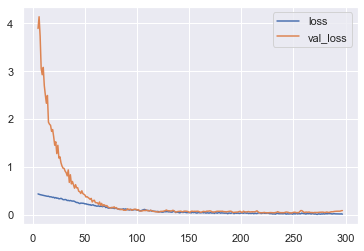

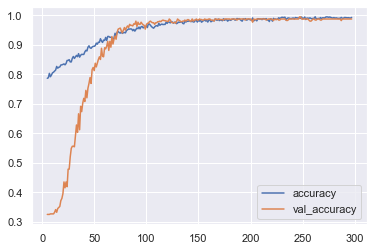

In [8]:
# Input-Daten
X = data_imputed[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
# Der Wert, der vorhergesagt werden soll
y = data_imputed['Outcome']

# Train-Test-Split als 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Outcome als kategorische Variable speichern
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

# Das Modell soll aufhören zu rechnen, falls es keine nennenswerten Verbesserungen mehr gibt
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=50,
    restore_best_weights=True
)

# Visualisierung mithilfe von TensorBoard
log_path="logs/fit/" + datetime.now().strftime("%d%m%Y-%H%M%S")
tensorboard = callbacks.TensorBoard(log_dir=log_path)

# Das NN besteht aus einer Mischung von Dense-, Normalization- und Dropout-Layern.
network = keras.Sequential([
    layers.BatchNormalization(dtype='float64'),
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(rate=0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax'),
])

network.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = network.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping, tensorboard],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +
      "\nBest Validation Accuracy: {:0.3f}%")\
      .format(history_df['val_loss'].min(), history_df['val_accuracy'].max()*100))

# Vorhersagen

In [11]:
pred_test= network.predict(X_test)
scores_test = network.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test data: {np.round(scores_test[1]*100, 3)}% \nError on test data: {np.round((1 - scores_test[1])*100, 3)}%')

Accuracy on test data: 99.458% 
Error on test data: 0.542%


In [14]:
#%tensorboard --logdir logs